In [ ]:
import numpy as np
import meshio
from scipy.ndimage import distance_transform_edt
from skimage.measure import marching_cubes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def mesh_to_voxels(vertices, faces, resolution):
    """Convert mesh to voxel grid with signed distance field."""
    # Get bounding box with padding
    min_bound = vertices.min(axis=0)
    max_bound = vertices.max(axis=0)
    padding = 0.1 * (max_bound - min_bound)
    min_bound -= padding
    max_bound += padding
    
    # Create voxel grid
    grid_shape = (resolution, resolution, resolution)
    x = np.linspace(min_bound[0], max_bound[0], resolution)
    y = np.linspace(min_bound[1], max_bound[1], resolution)
    z = np.linspace(min_bound[2], max_bound[2], resolution)
    
    # Create mesh grid
    xv, yv, zv = np.meshgrid(x, y, z, indexing='ij')
    points = np.stack([xv.ravel(), yv.ravel(), zv.ravel()], axis=1)
    
    # Compute signed distance field (simplified: just distance to nearest vertex)
    # For better results, use proper point-to-mesh distance
    voxel_grid = np.zeros(grid_shape)
    
    for i in range(resolution):
        for j in range(resolution):
            for k in range(resolution):
                point = np.array([x[i], y[j], z[k]])
                # Distance to nearest vertex (simple approximation)
                dist = np.min(np.linalg.norm(vertices - point, axis=1))
                voxel_grid[i, j, k] = dist
    
    # Make it signed (negative inside, positive outside)
    # Simple heuristic: if close to vertices, assume inside
    threshold = np.percentile(voxel_grid, 30)
    voxel_grid = np.where(voxel_grid < threshold, -voxel_grid, voxel_grid)
    
    return voxel_grid, (min_bound, max_bound)

def mesh_to_voxels_fast(vertices, faces, resolution):
    """Faster voxelization using rasterization approach."""
    min_bound = vertices.min(axis=0)
    max_bound = vertices.max(axis=0)
    padding = 0.05 * (max_bound - min_bound)
    min_bound -= padding
    max_bound += padding
    
    # Initialize binary voxel grid
    voxel_grid = np.zeros((resolution, resolution, resolution), dtype=bool)
    
    # Voxelize by checking if voxel centers are inside mesh
    spacing = (max_bound - min_bound) / resolution
    
    for face in faces:
        v0, v1, v2 = vertices[face]
        # Get bounding box of triangle in voxel space
        tri_min = ((np.min([v0, v1, v2], axis=0) - min_bound) / spacing).astype(int)
        tri_max = ((np.max([v0, v1, v2], axis=0) - min_bound) / spacing).astype(int)
        
        # Clamp to grid bounds
        tri_min = np.maximum(tri_min, 0)
        tri_max = np.minimum(tri_max, resolution - 1)
        
        # Mark voxels in bounding box
        for i in range(tri_min[0], tri_max[0] + 1):
            for j in range(tri_min[1], tri_max[1] + 1):
                for k in range(tri_min[2], tri_max[2] + 1):
                    voxel_grid[i, j, k] = True
    
    # Convert to signed distance field
    # Inside = negative, outside = positive
    sdf = distance_transform_edt(~voxel_grid) - distance_transform_edt(voxel_grid)
    
    return sdf, (min_bound, max_bound)

def coarsen_mesh_marching_cubes(input_file, output_prefix, target_vertices=[256, 512, 1024]):
    """Create coarser meshes using voxelization and marching cubes."""
    # Read input mesh
    mesh = meshio.read(input_file)
    vertices = mesh.points
    faces = mesh.cells_dict.get('triangle', mesh.cells_dict.get('polygon', None))
    
    if faces is None:
        raise ValueError("No triangle or polygon cells found in mesh")
    
    print(f"Input mesh: {len(vertices)} vertices, {len(faces)} faces")
    
    results = []
    
    for target_v in target_vertices:
        # For COARSENING: lower resolution = fewer vertices
        # Empirically tuned: resolution^2 * ~4.8 ≈ vertex count for marching cubes
        resolution = int(np.sqrt(target_v / 4.8))
        resolution = max(6, min(resolution, 64))  # Clamp between 6 and 64
        
        print(f"\nCreating mesh with ~{target_v} vertices (resolution={resolution})...")
        
        # Voxelize mesh
        print("  Voxelizing...")
        sdf, (min_bound, max_bound) = mesh_to_voxels_fast(vertices, faces, resolution)
        
        # Apply marching cubes
        print("  Running marching cubes...")
        try:
            verts_mc, faces_mc, normals, values = marching_cubes(
                sdf, 
                level=0,
                spacing=((max_bound - min_bound) / resolution)
            )
            
            # Offset vertices to world coordinates
            verts_mc += min_bound
            
            # Save mesh
            output_file = f"{output_prefix}_{len(verts_mc)}v.obj"
            output_mesh = meshio.Mesh(
                points=verts_mc,
                cells=[("triangle", faces_mc)]
            )
            meshio.write(output_file, output_mesh)
            
            print(f"  Saved: {output_file} ({len(verts_mc)} vertices, {len(faces_mc)} faces)")
            results.append((output_file, len(verts_mc)))
            
        except Exception as e:
            print(f"  Error: {e}")
    
    return results

Input mesh: 2503 vertices, 4968 faces

Creating mesh with ~256 vertices (resolution=7)...
  Voxelizing...
  Running marching cubes...
  Saved: coarse_187v.obj (187 vertices, 293 faces)

Creating mesh with ~512 vertices (resolution=10)...
  Voxelizing...
  Running marching cubes...
  Saved: coarse_484v.obj (484 vertices, 862 faces)

Creating mesh with ~1024 vertices (resolution=14)...
  Voxelizing...
  Running marching cubes...
  Saved: coarse_1057v.obj (1057 vertices, 1988 faces)

Summary:
  coarse_187v.obj: 187 vertices
  coarse_484v.obj: 484 vertices
  coarse_1057v.obj: 1057 vertices

Generating plots...
Saved plot: coarse_comparison.png


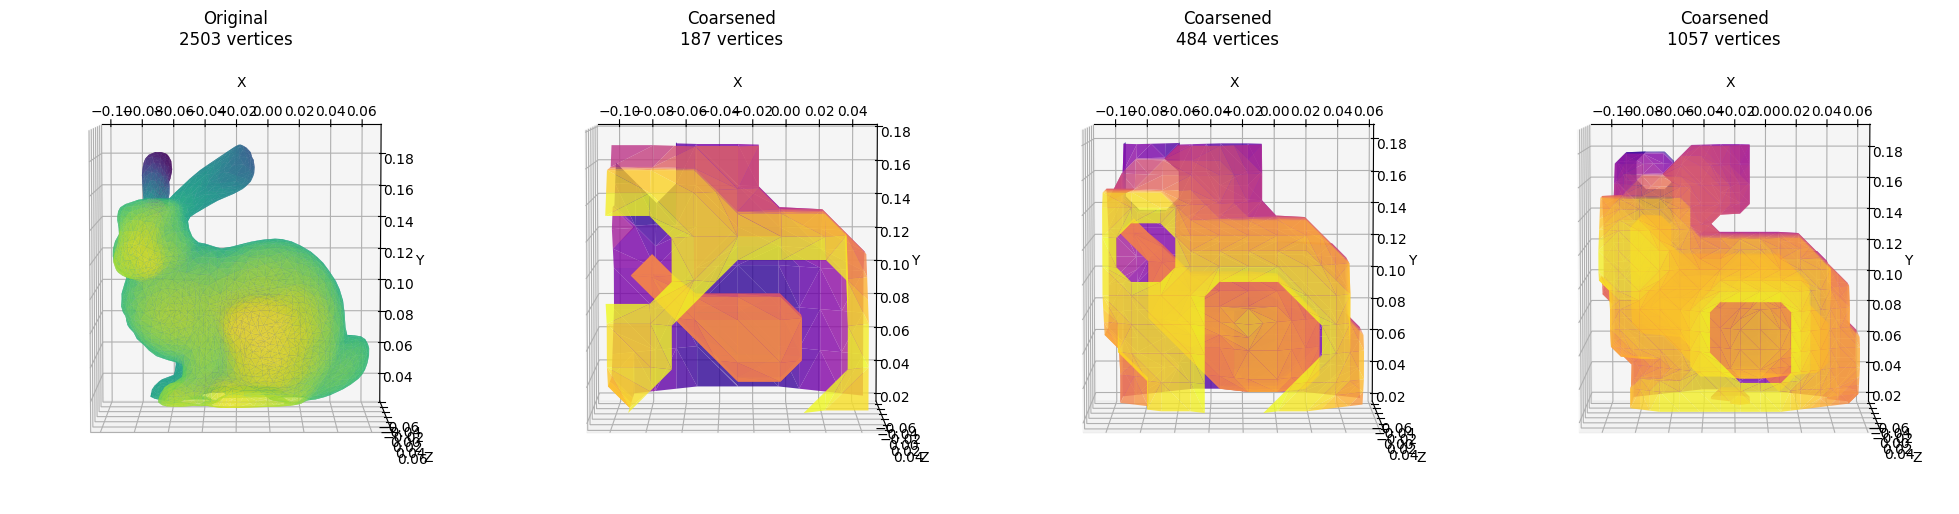

In [ ]:
input_mesh = "../resources/bunny.obj"  # Replace with your mesh file
output_prefix = "coarse"

results = coarsen_mesh_marching_cubes(
    input_mesh,
    output_prefix,
    target_vertices=[256, 512, 1024]
)

print("\n" + "="*50)
print("Summary:")
for filename, vertex_count in results:
    print(f"  {filename}: {vertex_count} vertices")

# Plot the coarsened meshes
print("\nGenerating plots...")
n_meshes = len(results) + 1  # +1 for original
fig = plt.figure(figsize=(5*n_meshes, 5))

# Plot original mesh
original_mesh = meshio.read(input_mesh)
original_faces = original_mesh.cells_dict.get('triangle', original_mesh.cells_dict.get('polygon', None))
ax = fig.add_subplot(1, n_meshes, 1, projection='3d')
ax.plot_trisurf(original_mesh.points[:, 0], 
                original_mesh.points[:, 1], 
                original_mesh.points[:, 2],
                triangles=original_faces,
                cmap='viridis', 
                alpha=0.8, 
                edgecolor='none')
ax.set_title(f'Original\n{len(original_mesh.points)} vertices')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=95, azim=-90)

# Plot coarsened meshes
for idx, (filename, vertex_count) in enumerate(results, start=2):
    coarse_mesh = meshio.read(filename)
    coarse_faces = coarse_mesh.cells_dict.get('triangle', coarse_mesh.cells_dict.get('polygon', None))
    ax = fig.add_subplot(1, n_meshes, idx, projection='3d')
    ax.plot_trisurf(coarse_mesh.points[:, 0], 
                    coarse_mesh.points[:, 1], 
                    coarse_mesh.points[:, 2],
                    triangles=coarse_faces,
                    cmap='plasma', 
                    alpha=0.8, 
                    edgecolor='none')
    ax.set_title(f'Coarsened\n{vertex_count} vertices')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=95, azim=-90)


plt.tight_layout()
plt.savefig(f'{output_prefix}_comparison.png', dpi=150, bbox_inches='tight')
print(f"Saved plot: {output_prefix}_comparison.png")
plt.show()


In [73]:
import numpy as np
import meshio
import pyvista as pv

def simplify_mesh_decimation(input_file, output_prefix, target_vertices=[256, 512, 1024]):
    """Simplify mesh using quadric decimation algorithm."""
    # Read input mesh
    mesh = meshio.read(input_file)
    vertices = mesh.points
    faces = mesh.cells_dict.get('triangle', mesh.cells_dict.get('polygon', None))
    
    if faces is None:
        raise ValueError("No triangle or polygon cells found in mesh")
    
    print(f"Input mesh: {len(vertices)} vertices, {len(faces)} faces")
    
    # Convert to PyVista mesh
    faces_pv = np.hstack([[3] + list(face) for face in faces])
    pv_mesh = pv.PolyData(vertices, faces_pv)
    
    results = []
    
    for target_v in target_vertices:
        print(f"\nSimplifying to ~{target_v} vertices...")
        
        # Calculate target reduction ratio
        reduction = 1.0 - (target_v / len(vertices))
        reduction = max(0.0, min(0.99, reduction))  # Clamp between 0 and 0.99
        
        print(f"  Target reduction: {reduction*100:.1f}%")
        
        # Apply decimation
        simplified = pv_mesh.decimate(
            reduction,
            volume_preservation=True
        )
        
        # Extract vertices and faces
        verts_simplified = simplified.points
        faces_simplified = simplified.faces.reshape(-1, 4)[:, 1:4]
        
        # Save mesh
        output_file = f"{output_prefix}_{len(verts_simplified)}v.obj"
        output_mesh = meshio.Mesh(
            points=verts_simplified,
            cells=[("triangle", faces_simplified)]
        )
        meshio.write(output_file, output_mesh)
        
        print(f"  Saved: {output_file} ({len(verts_simplified)} vertices, {len(faces_simplified)} faces)")
        results.append((output_file, len(verts_simplified)))
    
    return results


Input mesh: 2503 vertices, 4968 faces

Simplifying to ~256 vertices...
  Target reduction: 89.8%
  Saved: simplified_261v.obj (261 vertices, 507 faces)

Simplifying to ~512 vertices...
  Target reduction: 79.5%
  Saved: simplified_518v.obj (518 vertices, 1016 faces)

Simplifying to ~1024 vertices...
  Target reduction: 59.1%
  Saved: simplified_1030v.obj (1030 vertices, 2031 faces)

Summary:
  simplified_261v.obj: 261 vertices
  simplified_518v.obj: 518 vertices
  simplified_1030v.obj: 1030 vertices

Generating plots...
Saved plot: simplified_comparison.png


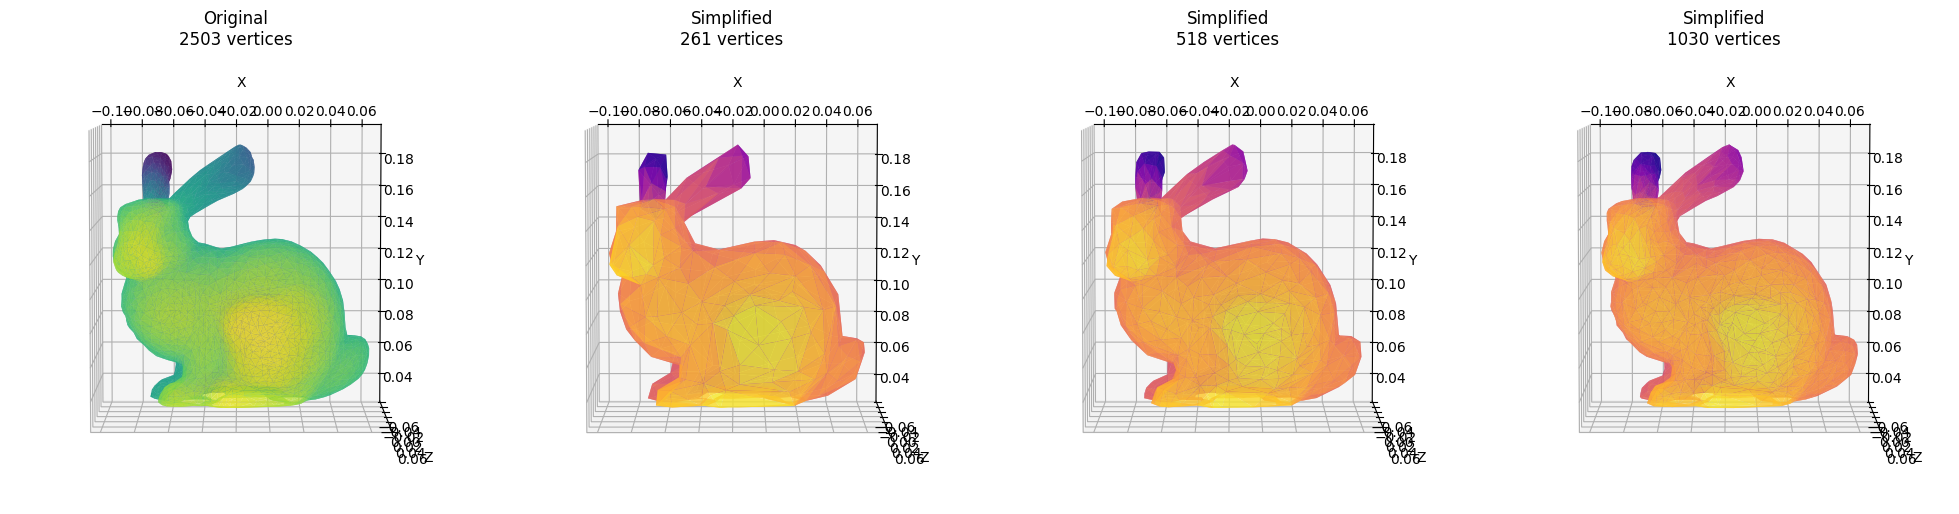

In [75]:


input_mesh = "../resources/bunny.obj"  # Replace with your mesh file
output_prefix = "simplified"

results = simplify_mesh_decimation(
    input_mesh,
    output_prefix,
    target_vertices=[256, 512, 1024]
)

print("\n" + "="*50)
print("Summary:")
for filename, vertex_count in results:
    print(f"  {filename}: {vertex_count} vertices")

# Plot the simplified meshes
print("\nGenerating plots...")
n_meshes = len(results) + 1  # +1 for original
fig = plt.figure(figsize=(5*n_meshes, 5))

# Plot original mesh
original_mesh = meshio.read(input_mesh)
original_faces = original_mesh.cells_dict.get('triangle', original_mesh.cells_dict.get('polygon', None))
ax = fig.add_subplot(1, n_meshes, 1, projection='3d')
ax.plot_trisurf(original_mesh.points[:, 0], 
                original_mesh.points[:, 1], 
                original_mesh.points[:, 2],
                triangles=original_faces,
                cmap='viridis', 
                alpha=0.8, 
                edgecolor='none')
ax.set_title(f'Original\n{len(original_mesh.points)} vertices')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=95, azim=-90)

# Plot simplified meshes
for idx, (filename, vertex_count) in enumerate(results, start=2):
    simplified_mesh = meshio.read(filename)
    simplified_faces = simplified_mesh.cells_dict.get('triangle', simplified_mesh.cells_dict.get('polygon', None))
    ax = fig.add_subplot(1, n_meshes, idx, projection='3d')
    ax.plot_trisurf(simplified_mesh.points[:, 0], 
                    simplified_mesh.points[:, 1], 
                    simplified_mesh.points[:, 2],
                    triangles=simplified_faces,
                    cmap='plasma', 
                    alpha=0.8, 
                    edgecolor='none')
    ax.set_title(f'Simplified\n{vertex_count} vertices')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=95, azim=-90)

plt.tight_layout()
plt.savefig(f'{output_prefix}_comparison.png', dpi=150, bbox_inches='tight')
print(f"Saved plot: {output_prefix}_comparison.png")
plt.show()